Poniższy dokument stanowi opracowanie części projektu dotyczącej analizy modeli regresji. 

In [1]:
import datetime, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso,LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV

# Wczytanie danych 

Wczytano dane po preprocessingu wykonanym podczas eksploracyjnej analizy danych.

In [2]:
flights=pd.read_csv("flights_explored.csv")

# Przygotowanie danych do modeli

Przygotowanie wartości kategorycznych

In [3]:
le = LabelEncoder()

In [4]:
flights['AIRLINE']= le.fit_transform(flights['AIRLINE'])
flights['ORIGIN_AIRPORT'] = le.fit_transform(flights['ORIGIN_AIRPORT'])
flights['DESTINATION_AIRPORT'] = le.fit_transform(flights['DESTINATION_AIRPORT'])
flights = flights.drop(['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL'], axis = 1)

## Dane do trenowania modeli bez uwzględniania DEPARTURE_DELAY

Zrezygnowano jeszcze z kilku cech, w tym z niewygodnych danych opisujących czasy (wylotu/przylotu).

In [5]:
X = flights.drop(['ARRIVAL_DELAY','TAIL_NUMBER','DEPARTURE_DELAY','DEPARTURE_TIME','ARRIVAL_TIME'],axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026542 entries, 0 to 3026541
Data columns (total 10 columns):
MONTH                  int64
DAY_OF_WEEK            int64
ORIGIN_AIRPORT         int64
DESTINATION_AIRPORT    int64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
AIRLINE                int64
DELAYED                bool
dtypes: bool(1), float64(3), int64(6)
memory usage: 210.7 MB


Cechą wynikową jest opóźnienie po przylocie.

In [6]:
y = flights['ARRIVAL_DELAY']
y.head()

0   -22.0
1   -21.0
2   -14.0
3   -18.0
4    -3.0
Name: ARRIVAL_DELAY, dtype: float64

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 2)

In [8]:
sc1=StandardScaler()
X_train_sc=sc1.fit_transform(X_train)
X_test_sc=sc1.transform(X_test)

## Dane do końcowego testu wybranego modelu uwzględniając DEPARTURE_DELAY

In [9]:
'''
flights=pd.read_csv("flights_explored.csv")
flights['AIRLINE']= le.fit_transform(flights['AIRLINE'])
flights['ORIGIN_AIRPORT'] = le.fit_transform(flights['ORIGIN_AIRPORT'])
flights['DESTINATION_AIRPORT'] = le.fit_transform(flights['DESTINATION_AIRPORT'])
flights = flights.drop(['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL'], axis = 1)
'''

'\nflights=pd.read_csv("flights_explored.csv")\nflights[\'AIRLINE\']= le.fit_transform(flights[\'AIRLINE\'])\nflights[\'ORIGIN_AIRPORT\'] = le.fit_transform(flights[\'ORIGIN_AIRPORT\'])\nflights[\'DESTINATION_AIRPORT\'] = le.fit_transform(flights[\'DESTINATION_AIRPORT\'])\nflights = flights.drop([\'SCHEDULED_DEPARTURE\',\'SCHEDULED_ARRIVAL\'], axis = 1)\n'

In [10]:
X_d = flights.drop(['ARRIVAL_DELAY','TAIL_NUMBER','DEPARTURE_TIME','ARRIVAL_TIME'],axis = 1)
y_d = flights['ARRIVAL_DELAY']

In [11]:
X_train_d,X_test_d,y_train_d,y_test_d = train_test_split(X_d,y_d,test_size=0.3,random_state = 2)

In [12]:
sc1=StandardScaler()
X_train_sc_d=sc1.fit_transform(X_train_d)
X_test_sc_d=sc1.transform(X_test_d)

# Regularyzacja -- dobór parametru dla modelu Lasso i Ridge regresji

Wykorzystaliśmy parametr cv=2 GridSearcgCV, aby na niespacjalnie wydolnym sprzęcie w sensownym czasie rozprawić się z danymi.

In [13]:
def regularyzacja(model,param):
    model_regressor=GridSearchCV(Lasso(),param,scoring='neg_mean_squared_error',cv=2,verbose=10)
    model_regressor.fit(X_train_sc,y_train)
    print(model_regressor.best_params_)
    print(model_regressor.best_score_)

In [14]:
param={'alpha':[1e-20,1e-8,1e-3,10]}
regularyzacja(Ridge(),param)

"\nparam={'alpha':[1e-20,1e-8,1e-3,10]}\nregularyzacja(Ridge(),param)\n"

In [15]:
regularyzacja(Lasso(),param)

'\nregularyzacja(Lasso(),param)\n'

W naszym przypadku zauważyliśmy, że im mniejszy hiperparametr, tym lepsze osiągane wyniki (aczkolwiek nadal mało satysfakcjonujące)

# Przygotowanie modeli

In [16]:
Las = Lasso(alpha=1e-20)
LinR = LinearRegression()
Rid = Ridge(alpha=1e-20)
Boost_Lin = AdaBoostRegressor(base_estimator=LinR,random_state=2)
Boost_las = AdaBoostRegressor(base_estimator=Las,random_state=2)
Boost_rid = AdaBoostRegressor(base_estimator=Rid,random_state=2)
Bg_Lin = BaggingRegressor(base_estimator=LinR,random_state=2)
Bg_las = BaggingRegressor(base_estimator=Las,random_state=2)
Bg_rid = BaggingRegressor(base_estimator=Rid,random_state=2)

# Podstawowe regressory

In [17]:
def errors_for_regressor(X_train,X_test,y_train,models,names):
    for model, name in zip(models,names):
        model1 = model.fit(X_train,y_train)
        Y_predict=model1.predict(X_test)
        print(name)
        print('Mean Absolute Error:', mean_absolute_error(y_test, Y_predict))  
        print('Mean Squared Error:', mean_squared_error(y_test, Y_predict))  
        print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, Y_predict)))
        print('R2 : ',r2_score(y_test, Y_predict))
        print()
        print(name)
        plt.scatter(y_test, Y_predict)
        plt.title("Model Analysis")
        plt.xlabel("Real Value")
        plt.ylabel("Prediction")
        plt.show()

In [18]:
models=[Las,LinR,Rid]
names=['Lasso','Linear','Ridge']

Analiza błędów dla modeli uwzględniających regularyzację. W poniższych przykładach nie wzięliśmy pod uwagę cechy DEPARTURE_DELAY.

Do porównania jakości modeli predykcyjnych zastosowaliśmy następujące metryki:
- MAE
- MSE
- RMSE
- R2

/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178285242.9381485, tolerance: 345343.7827664025
  positive)


Lasso
Mean Absolute Error: 15.283811704880794
Mean Squared Error: 1127.2523119337066
Root Mean Squared Error: 33.57457835824162
R2 :  0.3135032425379226

Lasso


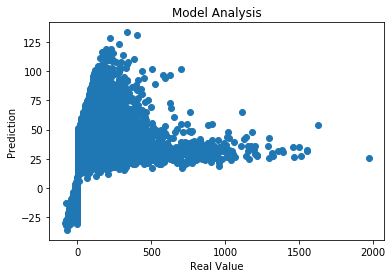

Linear
Mean Absolute Error: 15.283811713379887
Mean Squared Error: 1127.2523119569842
Root Mean Squared Error: 33.574578358588276
R2 :  0.3135032425237465

Linear


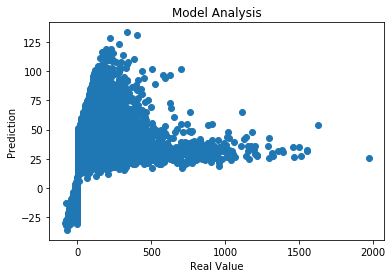

Ridge
Mean Absolute Error: 15.283811713380311
Mean Squared Error: 1127.2523119569848
Root Mean Squared Error: 33.57457835858828
R2 :  0.31350324252374606

Ridge


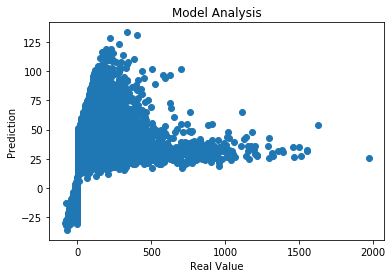

In [19]:
errors_for_regressor(X_train_sc,X_test_sc,y_train,models,names)

W poniższych przykładach wzięliśmy pod uwagę cechę DEPARTURE_DELAY.

Lasso
Mean Absolute Error: 0.038227810334522064
Mean Squared Error: 0.0027469982837444577
Root Mean Squared Error: 0.052411814352724496
R2 :  0.9999983270778028

Lasso


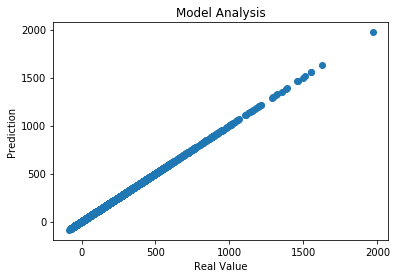

Linear
Mean Absolute Error: 5.6354903758030714e-14
Mean Squared Error: 6.908454629085402e-27
Root Mean Squared Error: 8.311711393621294e-14
R2 :  1.0

Linear


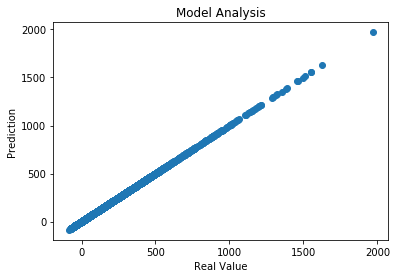

Ridge
Mean Absolute Error: 2.506040217111387e-12
Mean Squared Error: 1.3768398558972216e-23
Root Mean Squared Error: 3.710579275392484e-12
R2 :  1.0

Ridge


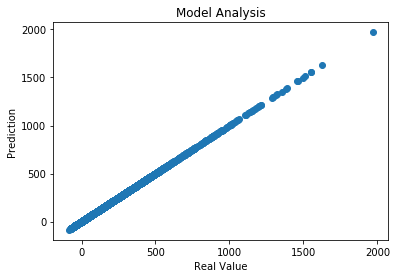

In [20]:
errors_for_regressor(X_train_sc_d,X_test_sc_d,y_train_d,models,names)

Czego się można było spodziewać, przy użyciu mocno skorelowanej z wyjściem cechy DEPARTURE_DELAY, dokładność modelu drastycznie poprawiła się.

# Boosting & bagging

Spróbowaliśmy również przeprowadzić boosting i bagging podstawowych modeli regresyjnych, ponownie porównaliśmy wyniki otrzymane przy uwzględnieniu mocno skorelowanej cechy DEPARTURE_DELAY oraz bez niej.

## Boosting

Spróbowaliśmy skorzystać z AdaBoost

Boosted Linear
Mean Absolute Error: 93.64773674741276
Mean Squared Error: 13977.838442142132
Root Mean Squared Error: 118.22790889693572
R2 :  -7.512504844987777

Boosted Linear


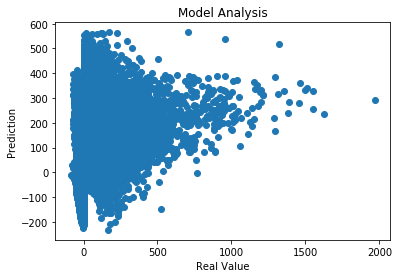

/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1186621325.574737, tolerance: 346854.9430767638
  positive)
/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5129264911.247938, tolerance: 1210960.2682821765
  positive)
/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66399214057.435875, tolerance: 16658030.022632593
  positive)
/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge.

Boosted Lasso
Mean Absolute Error: 93.04263788882152
Mean Squared Error: 13790.951153289288
Root Mean Squared Error: 117.43488047973348
R2 :  -7.398690469581197

Boosted Lasso


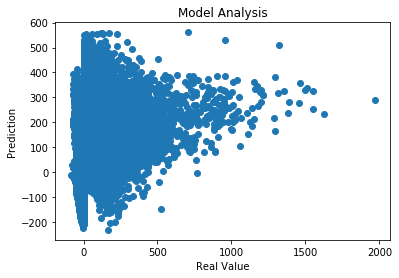

Boosted Ridge
Mean Absolute Error: 93.0355526784449
Mean Squared Error: 13789.562305505495
Root Mean Squared Error: 117.42896706309519
R2 :  -7.397844661158285

Boosted Ridge


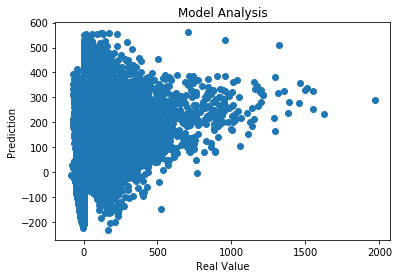

In [21]:
errors_for_regressor(X_train_sc,X_test_sc,y_train,[Boost_Lin,Boost_las,Boost_rid],['Boosted Linear','Boosted Lasso','Boosted Ridge'])

Boosted Linear
Mean Absolute Error: 3.9124343367112725e-14
Mean Squared Error: 2.426653716023703e-27
Root Mean Squared Error: 4.926107708956132e-14
R2 :  1.0

Boosted Linear


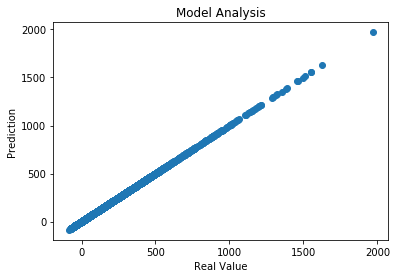

Boosted Lasso
Mean Absolute Error: 0.0119537419833688
Mean Squared Error: 0.0002607735880468408
Root Mean Squared Error: 0.016148485627043817
R2 :  0.9999998411888619

Boosted Lasso


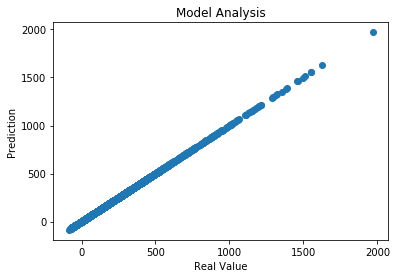

Boosted Ridge
Mean Absolute Error: 4.9134173241012714e-12
Mean Squared Error: 3.978602705309946e-23
Root Mean Squared Error: 6.307616590527634e-12
R2 :  1.0

Boosted Ridge


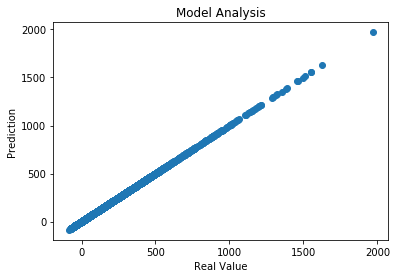

In [22]:
errors_for_regressor(X_train_sc_d,X_test_sc_d,y_train_d,[Boost_Lin,Boost_las,Boost_rid],['Boosted Linear','Boosted Lasso','Boosted Ridge'])

Widoczne jest pogorszenie wyników regresji. Próba zastosowania AdaBoost zakończyła się porażką.

# Bagging

Boosted Linear
Mean Absolute Error: 15.290909507612872
Mean Squared Error: 1127.2540348226596
Root Mean Squared Error: 33.574604015872765
R2 :  0.3135021932983981

Boosted Linear


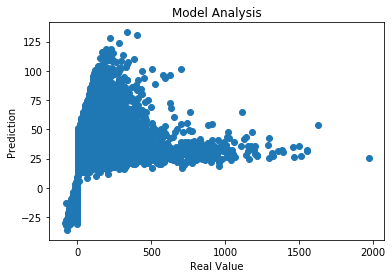

/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1194007922.583109, tolerance: 348863.6143615487
  positive)
/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1176849746.7383475, tolerance: 345149.5346857715
  positive)
/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1173706442.9345274, tolerance: 344682.4072673845
  positive)
/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. 

Boosted Lasso
Mean Absolute Error: 15.290906588271772
Mean Squared Error: 1127.2540331220184
Root Mean Squared Error: 33.574603990546464
R2 :  0.31350219433408877

Boosted Lasso


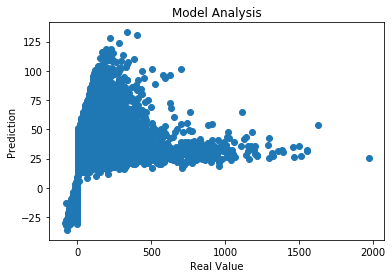

Boosted Ridge
Mean Absolute Error: 15.290906596789872
Mean Squared Error: 1127.2540331433588
Root Mean Squared Error: 33.57460399086427
R2 :  0.3135021943210924

Boosted Ridge


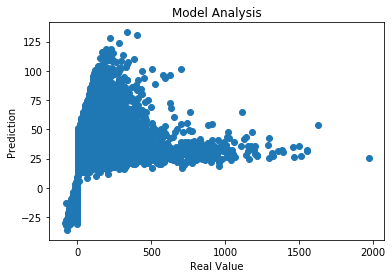

In [23]:
errors_for_regressor(X_train_sc,X_test_sc,y_train,[Bg_Lin,Bg_las,Bg_rid],['Boosted Linear','Boosted Lasso','Boosted Ridge'])

Bagged Linear
Mean Absolute Error: 3.171637944967651e-14
Mean Squared Error: 1.5997688674216135e-27
Root Mean Squared Error: 3.9997110738422265e-14
R2 :  1.0

Bagged Linear


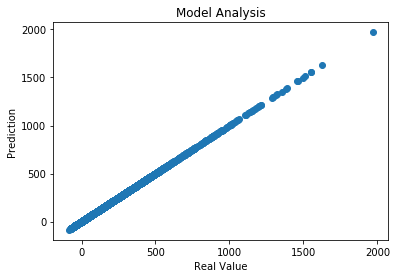

Bagged Lasso
Mean Absolute Error: 0.038156798436667284
Mean Squared Error: 0.002734392918000745
Root Mean Squared Error: 0.052291422986955945
R2 :  0.9999983347544716

Bagged Lasso


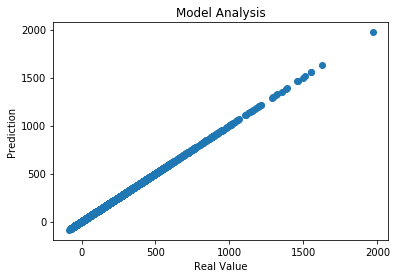

Bagged Ridge
Mean Absolute Error: 1.8457384732654104e-12
Mean Squared Error: 5.098570439736326e-24
Root Mean Squared Error: 2.258001425981907e-12
R2 :  1.0

Bagged Ridge


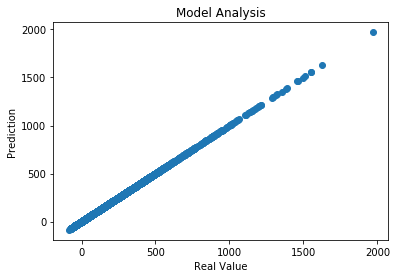

In [24]:
errors_for_regressor(X_train_sc_d,X_test_sc_d,y_train_d,[Bg_Lin,Bg_las,Bg_rid],['Bagged Linear','Bagged Lasso','Bagged Ridge'])

# Wnioski 

* Do problemu stworzenia modelu regresyjnego podeszliśmy z założeniem wykorzystania koncepcji poznanych na zajęciach laboratoryjnych i wykładzie. Tymi technikami są regresja, regularyzacja, walidacja krzyżowa, boosting oraz bagging, metryki oceny jakości modelu. W zależności od tego czy korzystaliśmy w naszych predykcjach z jednej bardzo mocno skorelowanej z wyjściem cechy, można stwierdzić że odnieśliśmy spektakularny sukces czy ponieśliśmy sromotną porażkę. Na pewno naszym osobistym sukcesem jest fakt, że przećwiczyliśmy wiele technik poznanych na zajęciach.
* Zastosowanie regularyzacji znacznie poprawiło wyniki w niektórych analizowanych przypadkach (np. zastosowania Lasso Regression).
* Zastosowane metod boostingu oraz baggingu w przypadku naszych modeli bez zastosowania mocno skorelowanej cechy nie było pomocne. W przypadku korzystania z mocno skorelowanej cechy, zazobserowaliśmy znaczną poprawę metryk oceny jakości modelu.
* Wielokrotnie prace trwały długo ze względu na słabą wydajność prywatnych maszyn. Pomijając czas pracy maszyn, najdłużej w całym projekcie zastanawialiśmy się nad doborem cech i oczyszczeniem danych.
* Porównując wyniki użytych metryk oceny skuteczności modelu możemy stwierdzić, że w obu przypakach z uwzlędnianiem lub nie, cechę DEPARTURE_DELAY możemy stwierdzić że do postowionej hipotezy najbardziej się nadają podstawowe modele regresyjne (czyli Lasso, Ridge z regularyzacją oraz Liniowa regresja). 

Wnioski do części projektu będącej analizą eksplorayjną zawarto w notatniku z tą analizą.